# Evaluate Baseline GAT Model

This notebook performs comprehensive evaluation of the trained baseline GAT model.

## Overview
1. Load model and generate predictions
2. Confusion matrix analysis
3. Classification report
4. ROC curve and AUC
5. Temporal robustness evaluation
6. Identify top fraud cases for explanation

**Estimated time:** 2-5 minutes

In [1]:
import sys
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from pathlib import Path
import os

# Always add project root to sys.path for src imports (Jupyter-safe)
project_root = str(Path().resolve().parent)
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.models import GAT
from src.config import MODEL_CONFIG, TRAINING_CONFIG, EVAL_CONFIG, EXPLAIN_CONFIG, ARTIFACTS_DIR, FIGURES_DIR, ARTIFACT_FILES, FIGURE_FILES
from src.utils import get_device

device = get_device()

Device: cpu


## 1. Import Libraries & Setup

In [2]:
graph_path = ARTIFACTS_DIR / ARTIFACT_FILES['baseline_graph']
data = torch.load(graph_path, weights_only=False).to(device)

model = GAT(
    in_channels=data.num_node_features,
    hidden_channels=MODEL_CONFIG['hidden_channels'],
    out_channels=MODEL_CONFIG['out_channels'],
    num_heads=MODEL_CONFIG['num_heads'],
    num_layers=MODEL_CONFIG['num_layers'],
    dropout=MODEL_CONFIG['dropout']
).to(device)

model_path = ARTIFACTS_DIR / ARTIFACT_FILES['baseline_model']
checkpoint = torch.load(model_path, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Loaded model from epoch {checkpoint['epoch']}")

Loaded model from epoch 170


In [3]:
# Recreate data preprocessing and splits (same as in training)
from sklearn.model_selection import train_test_split

# Handle NaN values
nan_mask = torch.isnan(data.x)
if nan_mask.any():
    data.x = torch.where(nan_mask, torch.zeros_like(data.x), data.x)

# Get labeled indices
labeled_indices = torch.where(data.labeled_mask)[0].cpu().numpy()
labeled_y = data.y[data.labeled_mask].cpu().numpy()

# Recreate the same splits
train_val_idx, test_idx = train_test_split(
    labeled_indices, 
    test_size=TRAINING_CONFIG['train_test_split'], 
    random_state=TRAINING_CONFIG['random_seed'], 
    stratify=labeled_y
)

train_val_y = data.y[train_val_idx].cpu().numpy()
train_idx, val_idx = train_test_split(
    train_val_idx, 
    test_size=TRAINING_CONFIG['train_val_split'], 
    random_state=TRAINING_CONFIG['random_seed'], 
    stratify=train_val_y
)

# Create masks
train_mask = torch.zeros(data.num_nodes, dtype=torch.bool, device=device)
val_mask = torch.zeros(data.num_nodes, dtype=torch.bool, device=device)
test_mask = torch.zeros(data.num_nodes, dtype=torch.bool, device=device)

train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

# Normalize features (same as training)
train_x = data.x[data.train_mask]
mean = train_x.mean(dim=0, keepdim=True)
std = train_x.std(dim=0, keepdim=True)
std = torch.where(std == 0, torch.ones_like(std), std)
data.x = (data.x - mean) / std
data.x = torch.clamp(data.x, min=-10, max=10)

print(f"Data preprocessed - Train: {train_mask.sum()}, Val: {val_mask.sum()}, Test: {test_mask.sum()}")

Data preprocessed - Train: 27938, Val: 9313, Test: 9313


## 2. Load Data & Model

Load the saved graph and trained baseline model.

In [4]:
@torch.no_grad()
def get_predictions():
    out = model(data.x, data.edge_index)
    probs = F.softmax(out, dim=1)
    preds = out.argmax(dim=1)
    return preds, probs

predictions, probabilities = get_predictions()


## 3. Generate Predictions

Run inference to get predictions and probabilities for all nodes.

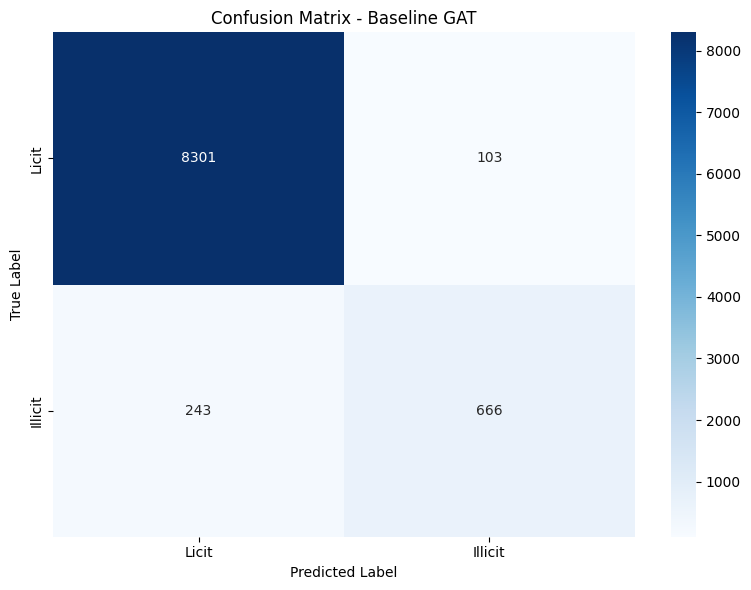


Confusion Matrix:
[[8301  103]
 [ 243  666]]


In [5]:
y_test = data.y[data.test_mask].cpu().numpy()
y_pred = predictions[data.test_mask].cpu().numpy()

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Licit', 'Illicit'],
            yticklabels=['Licit', 'Illicit'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - Baseline GAT')
plt.tight_layout()
save_path = FIGURES_DIR / FIGURE_FILES['baseline_confusion']
plt.savefig(save_path, dpi=150)
plt.show()

print("\nConfusion Matrix:")
print(cm)

## 4. Confusion Matrix

Visualize the confusion matrix on the test set.

In [6]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Licit', 'Illicit']))


Classification Report:
              precision    recall  f1-score   support

       Licit       0.97      0.99      0.98      8404
     Illicit       0.87      0.73      0.79       909

    accuracy                           0.96      9313
   macro avg       0.92      0.86      0.89      9313
weighted avg       0.96      0.96      0.96      9313



## 5. Classification Report

Detailed per-class metrics (precision, recall, F1-score).

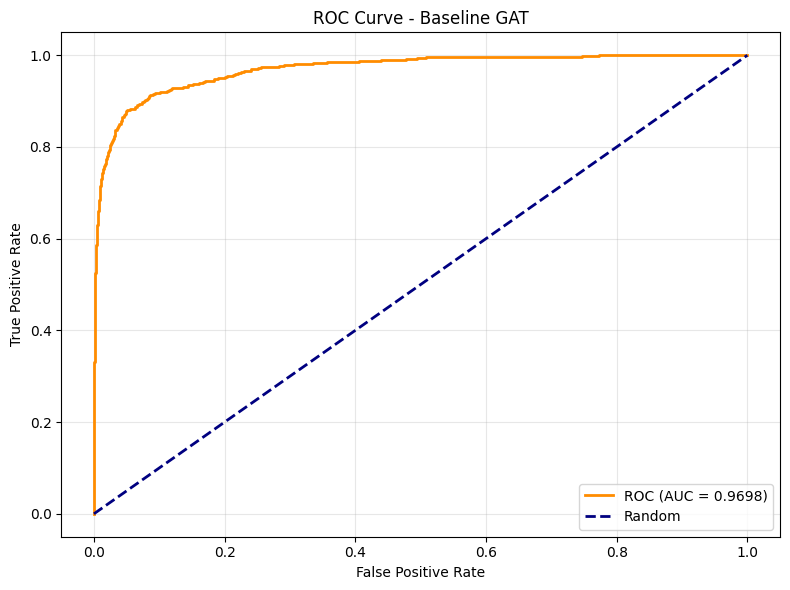

ROC-AUC: 0.9698


In [7]:
y_prob = probabilities[data.test_mask][:, 1].cpu().numpy()

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Baseline GAT')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
save_path = FIGURES_DIR / FIGURE_FILES['baseline_roc']
plt.savefig(save_path, dpi=150)
plt.show()

print(f"ROC-AUC: {roc_auc:.4f}")

## 6. ROC Curve & AUC

Plot ROC curve to evaluate model discrimination capability.

In [8]:
timesteps = data.timestep.cpu().numpy()
labeled_mask = data.labeled_mask.cpu().numpy()

temporal_split = np.percentile(timesteps[labeled_mask], EVAL_CONFIG['temporal_split_ratio'] * 100)
print(f"\nTemporal split at timestep: {temporal_split}")

temporal_train_mask = (timesteps <= temporal_split) & labeled_mask
temporal_test_mask = (timesteps > temporal_split) & labeled_mask

# Evaluate on temporal splits
from sklearn.metrics import f1_score, roc_auc_score

def eval_temporal(mask):
    y_true = data.y[mask].cpu().numpy()
    y_pred = predictions[mask].cpu().numpy()
    y_prob = probabilities[mask][:, 1].cpu().numpy()
    
    return {
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'auc': roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else 0.0
    }

early_metrics = eval_temporal(temporal_train_mask)
late_metrics = eval_temporal(temporal_test_mask)

print(f"\nEarly timesteps - F1: {early_metrics['f1']:.4f}, AUC: {early_metrics['auc']:.4f}")
print(f"Late timesteps  - F1: {late_metrics['f1']:.4f}, AUC: {late_metrics['auc']:.4f}")
print(f"Performance drop - F1: {early_metrics['f1'] - late_metrics['f1']:.4f}")


Temporal split at timestep: 36.0

Early timesteps - F1: 0.8244, AUC: 0.9795
Late timesteps  - F1: 0.6974, AUC: 0.9431
Performance drop - F1: 0.1270


## 7. Temporal Robustness Test

Evaluate how model performance changes over time.
Split data at 70th percentile timestep and compare early vs late performance.

In [9]:
fraud_scores = probabilities[:, 1].cpu().numpy()
num_top_fraud = EXPLAIN_CONFIG.get('num_top_fraud', 10)
top_fraud_idx = np.argsort(fraud_scores)[::-1][:num_top_fraud]

save_path = ARTIFACTS_DIR / ARTIFACT_FILES['top_fraud_indices']
np.save(save_path, top_fraud_idx)
print(f"\nTop {len(top_fraud_idx)} fraud cases saved to {save_path}")
print("Proceed to 05_quantum_feature_map.ipynb")


Top 10 fraud cases saved to C:\Users\tusha\Documents\UT_Dallas\ACM_SP26\Kryptos---Quantum-Blockchain-Fraud-Detection\artifacts\top_fraud_indices.npy
Proceed to 05_quantum_feature_map.ipynb


---

## ✅ Baseline Evaluation Complete!

Proceed to **05_quantum_feature_map.ipynb** to apply quantum-inspired feature transformation.

## 8. Save Top Fraud Cases

Identify and save the nodes with highest fraud probability for later explanation.